In [1]:
# Imports
library(Seurat)
library(SingleCellExperiment)
library(SingleR)
library(celldex)    
library(ggplot2)
library(clustree)
library(gridExtra)

Warning message:
"package 'Seurat' was built under R version 4.4.2"
Loading required package: SeuratObject

Warning message:
"package 'SeuratObject' was built under R version 4.4.2"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.4.2"

Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.4.2"

Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, 

In [39]:
# Change setting for visualizing plots within VSCODE
options(repr.plot.width=20, repr.plot.height=12)

In [ ]:
# Set wd
setwd("../../../Data/Vafadarnejad et al. (2020)")
list.files()
getwd()

# Change setting for visualizing plots within VSCODE
options(repr.plot.width=20, repr.plot.height=12)

# Read in data
HFD10_A <- Read10X(data.dir = "A11_filtered_gene_bc_matrices/mm10/")
HFD10_B <- Read10X(data.dir = "A12_filtered_gene_bc_matrices/mm10/")

# Create Seurat objects
HFD10_A <- CreateSeuratObject(HFD10_A, project="HFD 10")
HFD10_B <- CreateSeuratObject(HFD10_B, project="HFD 10")

# Merge the Seurat objects
sc.data <- merge(HFD10_A, y=HFD10_B,
                    add.cell.ids = c("A11", "A12"),
                    project="Merged version of A11 and A12")

# Merge layers
sc.data[["RNA"]] <- JoinLayers(sc.data[["RNA"]])

# Export R object for all mice integration
sc.data[["Species"]] <- "Mouse"
saveRDS(sc.data, file = "Vafadarnejad_raw.rds")

[1] "A11_filtered_gene_bc_matrices"         
[2] "A12_filtered_gene_bc_matrices"         
[3] "Vafadarnejad_macrophages_annotated.rds"
[4] "Vafadarnejad_raw.rds"                  
[5] "Vafadarnejad_raw_modified_orig.rds"

[1] "c:/Users/phili/Desktop/BMW Jaar 3/Afstudeerscriptie/project_scriptie/Data/Vafadarnejad et al. (2020)"

In [3]:
ncol(sc.data)

[1] 915

In [8]:
# Export R object for all mice integration
# We need to change orig.ident due to sample sizes
HFD_20weeks <- Read10X(data.dir = "A11_filtered_gene_bc_matrices/mm10/")
HFD_11weeks <- Read10X(data.dir = "A12_filtered_gene_bc_matrices/mm10/")

# Create Seurat obj
HFD10A_obj <- CreateSeuratObject(HFD_20weeks, project="HFD 10/11") # WD 20 weken
HFD10B_obj <- CreateSeuratObject(HFD_11weeks, project="HFD 10/11") # Chow 20 weken

# Merge the Seurat objects
sc.data2 <- merge(HFD10A_obj, y=HFD10B_obj,
                    add.cell.ids = c("HFD 10/11", "HFD 10/11"))

sc.data2[["Species"]] <- "Mouse"
saveRDS(sc.data2, file = "Vafadarnejad_raw_modified_orig.rds")

In [ ]:
# Preprocessing function which performs a basic workflow for scRNA seq analysis
pre_process <- function(data, nFeatures_RNA = 200, nCounts_RNA = 3, percents.mt = 5, pattern = "MT", resolutions = seq(0.5, 1.5, by = 0.1), k.weights = 100) {
    # Split
    data[["RNA"]] <- split(data[["RNA"]], f = data$orig.ident)

    # Get percentage mt                      
    data[["percent.mt"]] <- PercentageFeatureSet(data, pattern = sprintf("^%s-", pattern))

    # Subsets
    data <- subset(x = data, subset = nFeature_RNA >= nFeatures_RNA & nCount_RNA >= nCounts_RNA & percent.mt <= percents.mt)

    # Normalization
    data <- NormalizeData(data, normalization.method = "LogNormalize", scale.factor = 10000)
    
    # Find Variable features
    data <- FindVariableFeatures(data, selection.method = "vst", nfeatures = 2000)
    
    # Scale Data
    data <- ScaleData(data, vars.to.regress = c("percent.mt", "nFeature_RNA"))
    
    # Run PCA
    data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)

    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.05))

    # Run UMAP
    data <- RunUMAP(data, reduction = "pca", dims = 1:20, verbose=FALSE)

    # Integrate
    #data <- IntegrateLayers(
    #    object = data, 
    #    method = CCAIntegration, 
    #    orig.reduction = "pca", 
    #    new.reduction = "integrated.cca", 
    #    k.weight = k.weights,
    #    dims=1:20,
    #    verbose = FALSE)

    data[["RNA"]] <- JoinLayers(data[["RNA"]])

    # Post integration processing
    #data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)

    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.05))

    # Clustering
    data <- FindNeighbors(data, reduction = "pca", dims = 1:20)
    data <- FindClusters(data, resolution = resolutions)
    data <- RunUMAP(data, dims = 1:significant_pcs, reduction = "pca", verbose=FALSE)

    return(data)
}

#data <- pre_process(sc.data, pattern= "mt")

In [ ]:
# This cell is meant to analyze the different resolutions and see which one is the best
clustree(data, prefix= "RNA_snn_res.", layout = "sugiyama")

In [13]:
data <- readRDS("Vafadarnejad_macrophages_annotated.rds")

In [14]:
# Assign the slot "Seurat Cluster" to the desired resolution
data$seurat_clusters <- data$`RNA_snn_res.0.6`

,0,1,2,3,4,5,6,7,8,9,10
B cells,0,0,0,0,0,0,0,0,0,0,20
Dendritic cells,0,0,6,0,0,0,0,0,4,0,0
Erythrocytes,0,0,0,0,4,0,0,0,0,0,0
Fibroblasts,0,1,0,0,0,0,0,0,0,0,0
Granulocytes,0,0,0,0,1,0,0,1,23,0,0
Macrophages,1,126,1,0,0,0,42,4,0,0,0
Monocytes,2,66,86,0,3,0,3,3,0,0,0
NK cells,40,0,0,0,1,0,0,0,0,8,0
T cells,184,0,0,87,65,62,0,25,0,15,0


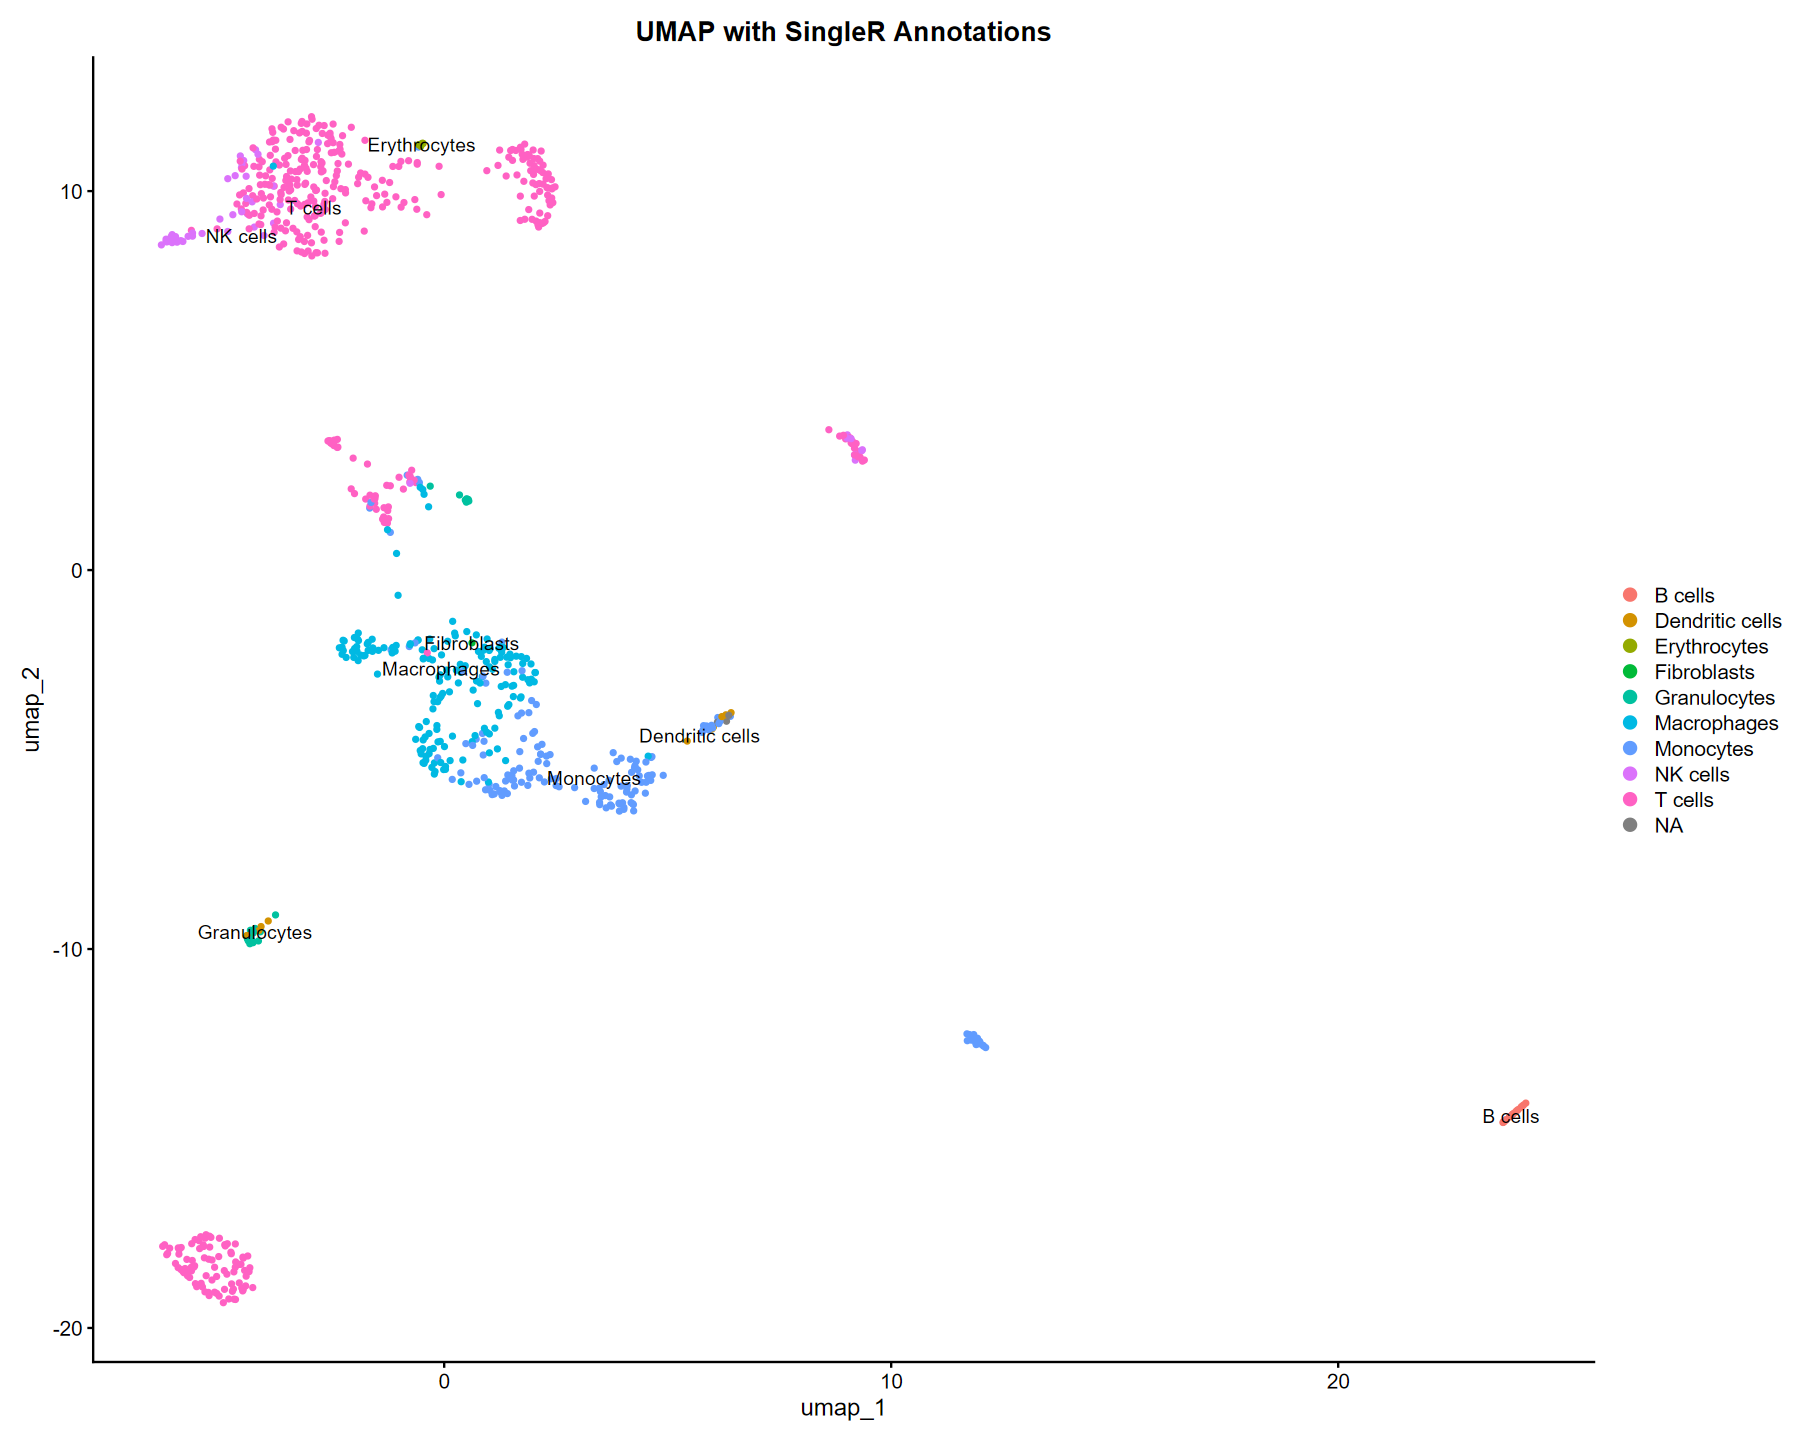

In [15]:
# Annotation
# Get reference atlas from CellDex
MouseRNAseqData <- celldex::MouseRNAseqData()

# Convert to SCE to use SingleR
data.sce <- as.SingleCellExperiment(data)

# Predict cell types
pred.MouseRNAseqData <- SingleR(test = data.sce, ref = MouseRNAseqData, assay.type.test=1,
    labels = MouseRNAseqData$label.main)

# View annotations
cluster_table <- cbind(table(pred.MouseRNAseqData$pruned.labels,data.sce$seurat_clusters))
cluster_table

# Add SingleR predicted labels to Seurat metadata
data$SingleR_Labels <- pred.MouseRNAseqData$pruned.labels

# UMAP plot with SingleR labels
DimPlot(data, reduction = "umap", group.by = "SingleR_Labels", label = TRUE) + 
    ggtitle("UMAP with SingleR Annotations")

In [20]:
# Function to get the a specific cell type
get_macrophages <- function(data, table, cell_type = "Macrophages") {

    # Find clusters where atleast > 15% is classified as macrophages
    clusters <- which(t(cluster_table[cell_type, ] / colSums(cluster_table) * 100) > 5) - 1

    # Get subsets by first filtering on macrophage dominant clusters
    data <- subset(data, subset = seurat_clusters %in% clusters)

    # And then only select the macrophages
    data <- subset(data, subset = SingleR_Labels == cell_type)

    return(data)
}

macrophages <- get_macrophages(data, cluster_table)

In [ ]:
# View distributions
table(macrophages$seurat_clusters)
macrophage_data <- CreateSeuratObject(counts = macrophages@assays$RNA$counts)


  0   1   2   3   4   5   6   7   8   9  10 
  0 126   0   0   0   0  42   0   0   0   0 

In [42]:
# Reprocess the subset
# To reintegrate, there needs to be a new Seurat Object created
macrophage_data <- CreateSeuratObject(counts = macrophages@assays$RNA$counts)
macrophage_data <- pre_process(macrophage_data, resolutions = seq(0.5, 1.5, by=0.1), k.weights = 10)

Normalizing layer: counts.A11

Normalizing layer: counts.A12

Finding variable features for layer counts.A11

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -1.3608"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.31941"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  7.6259e-29"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 0.090619"
Finding variable features for layer counts.A12

Regressing out percent.mt, nFeature_RNA

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
"You're computing too large a percentage of total singular values, use a standard svd instead."
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 172
Number of edges: 7137

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6295
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 172
Number of edges: 7137

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5787
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 172
Number of edges: 7137

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5280
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 172
Number of edges: 7137

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4774
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3

1 singletons identified. 4 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 172
Number of edges: 7137

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.2717
Number of communities: 6
Elapsed time: 0 seconds


1 singletons identified. 5 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 172
Number of edges: 7137

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.2443
Number of communities: 6
Elapsed time: 0 seconds


1 singletons identified. 5 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 172
Number of edges: 7137

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.2200
Number of communities: 7
Elapsed time: 0 seconds


2 singletons identified. 5 final clusters.



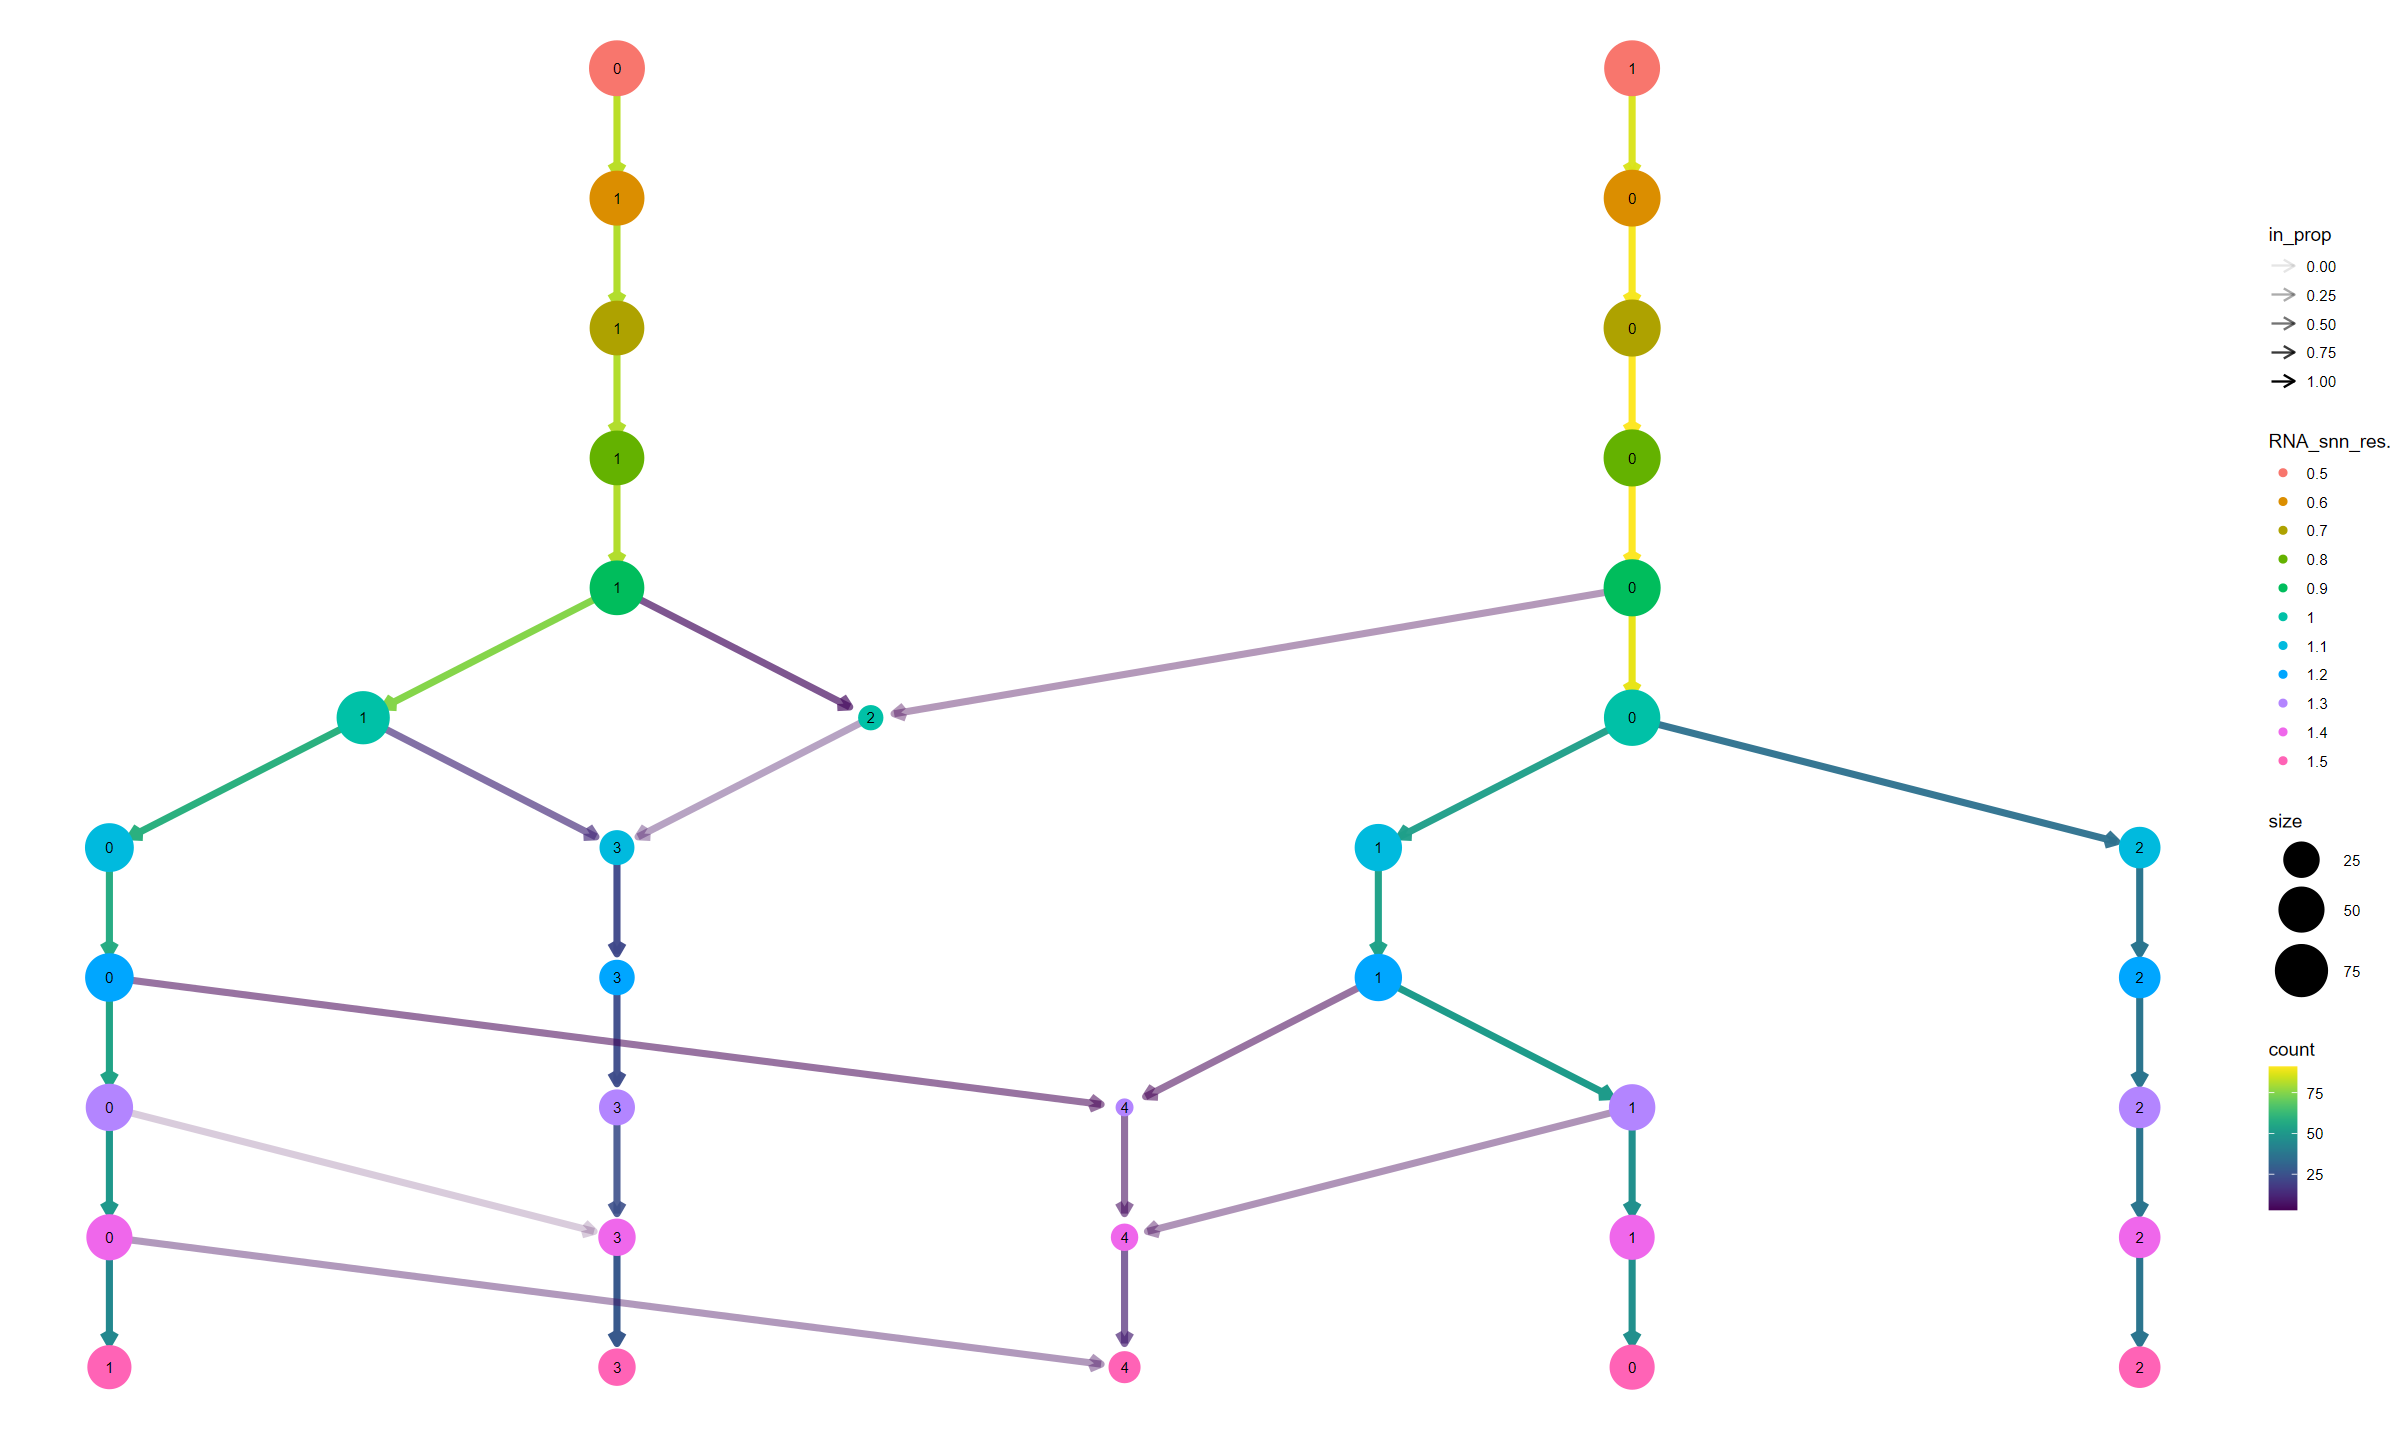

In [43]:
# View the clustree again for the best resolution
clustree(macrophage_data, prefix= "RNA_snn_res.", layout = "sugiyama")

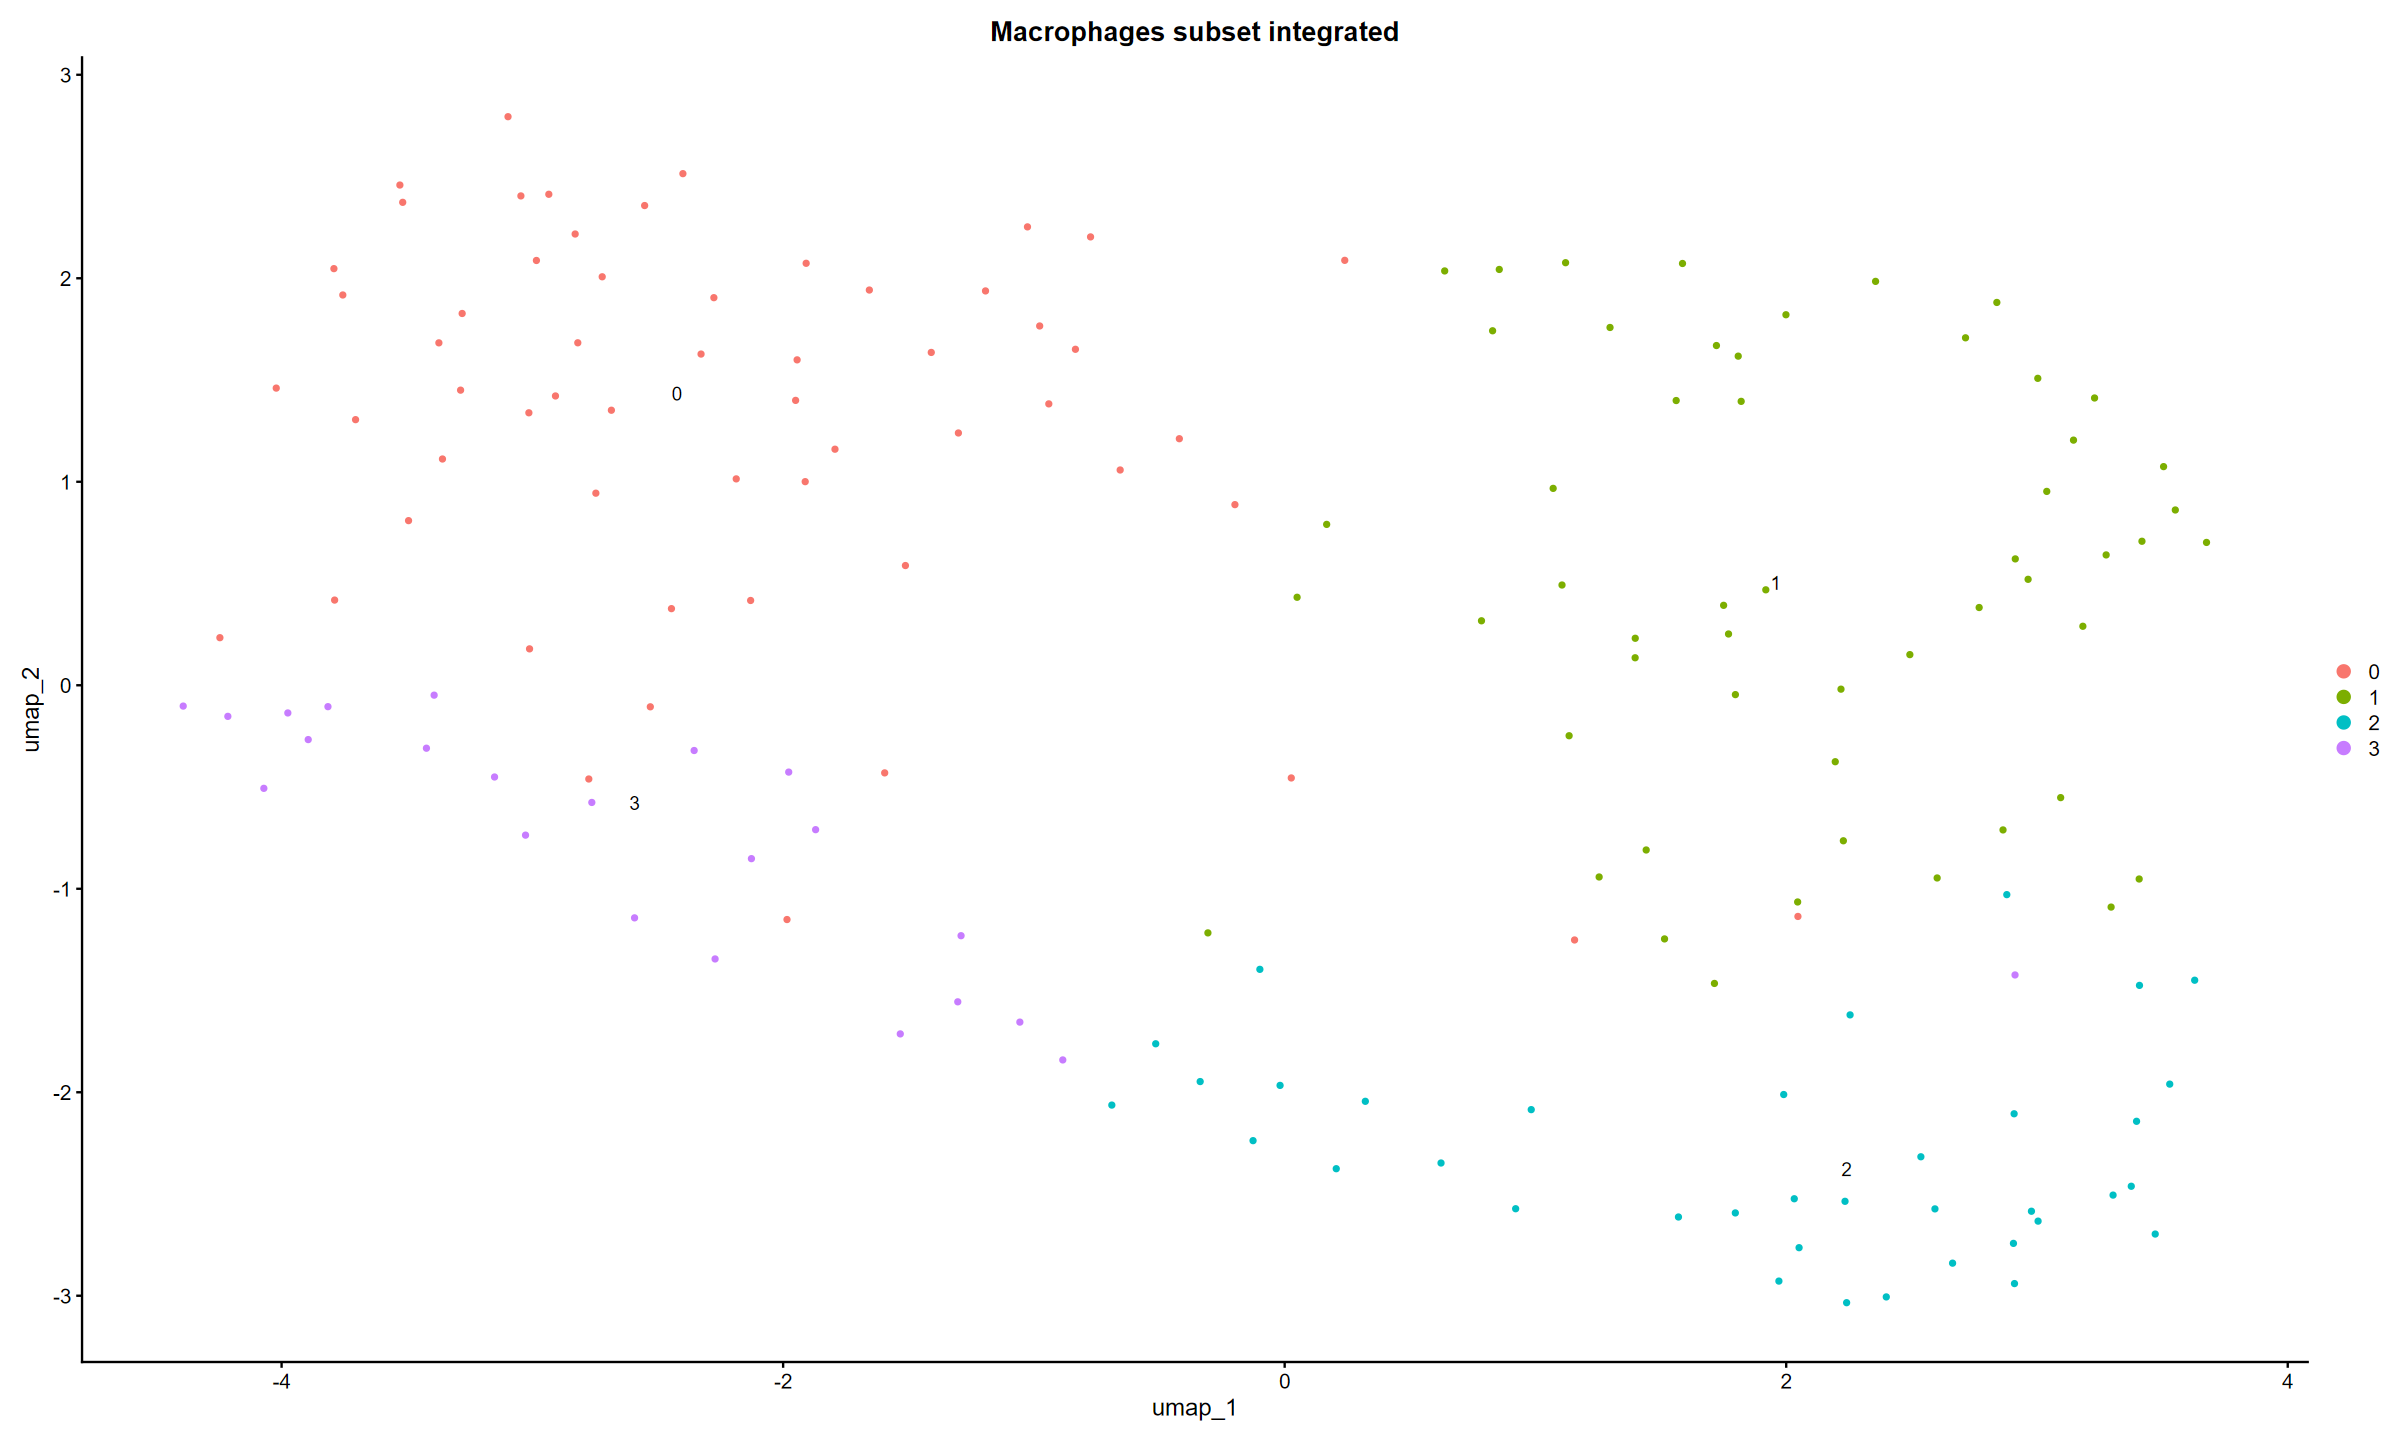

In [44]:
# Assign the slot "Seurat Cluster" to the desired resolution
macrophage_data$seurat_clusters <- macrophage_data$`RNA_snn_res.1.2`
Idents(macrophage_data) <- "seurat_clusters"

# Plot
DimPlot(macrophage_data, reduction = "umap", group.by = "RNA_snn_res.1.2", label = TRUE) + 
    ggtitle("Macrophages subset integrated")

In [45]:
# Some marker genes according to Winther & Willemsen
features_inflammatory <- c("S100a8", "S100a9", "Il1b", "Casp1", "Casp4", "Nlrp3", "Tnf", "Egr1", "Zpf36", "Ier3", "Cepbp", "Cxcl2", "Ccl2-5")
features_resident <- c("Lyve1", "Cx3cr1", "Folr2", "C1qa", "C1qb", "C1qc", "Cd74", "Hla-dra", "Hla-drb1", "Pf4", "Sepp1", "Vsig4", "F13a1")
features_trem2 <- c("Trem2", "Cd9", "Fabp5", "Apoe", "Apoc1", "Spp1", "Lgals3", "Ctsb")
features_ifnic <- c("Isg15", "Irf7", "Ifit3", "Ifit1")
features_proliferating <- c("Stmn1", "Top2a", "Mki67", "Tuba1b", "Tubb5")

# Add a module score to the Seurat object
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_inflammatory), name = "FeatureGeneScore_inflammatory")
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_resident), name = "FeatureGeneScore_resident_like")
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_trem2), name = "FeatureGeneScore_trem2")

# Vln plots
inflammatory_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_inflammatory1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for inflammatory macrophage markers")
residents_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_resident_like1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for resident-like macrophage markers")
trem2_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_trem21", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for trem2 foamy macrophage markers")

# Visualizing DotPlots to view marker genes
inflammatory_dot <- DotPlot(macrophage_data, features = features_inflammatory) + 
  ggtitle("Inflammatory Macrophages") + RotatedAxis()

resident_dot <- DotPlot(macrophage_data, features = features_resident) + 
  ggtitle("Resident-Like Macrophages")

TREM2_dot <- DotPlot(macrophage_data, features = features_trem2) + 
  ggtitle("TREM2 'Foamy' Macrophages")

IFNIC_dot <- DotPlot(macrophage_data, features = features_ifnic) + 
  ggtitle("IFNIC Macrophages")

proliferating_dot <- DotPlot(macrophage_data, features = features_proliferating) + 
  ggtitle("Proliferating Macrophages")


Warning message:
"The following features are not present in the object: Zpf36, Cepbp, Ccl2-5, not searching for symbol synonyms"


Warning message:
"The following features are not present in the object: Hla-dra, Hla-drb1, not searching for symbol synonyms"
Warning message:
"The following requested variables were not found: Zpf36, Cepbp, Ccl2-5"
Warning message:
"Scaling data with a low number of groups may produce misleading results"
Warning message:
"The following requested variables were not found: Hla-dra, Hla-drb1"
Warning message:
"Scaling data with a low number of groups may produce misleading results"
Warning message:
"Scaling data with a low number of groups may produce misleading results"
Warning message:
"Scaling data with a low number of groups may produce misleading results"
Warning message:
"Scaling data with a low number of groups may produce misleading results"


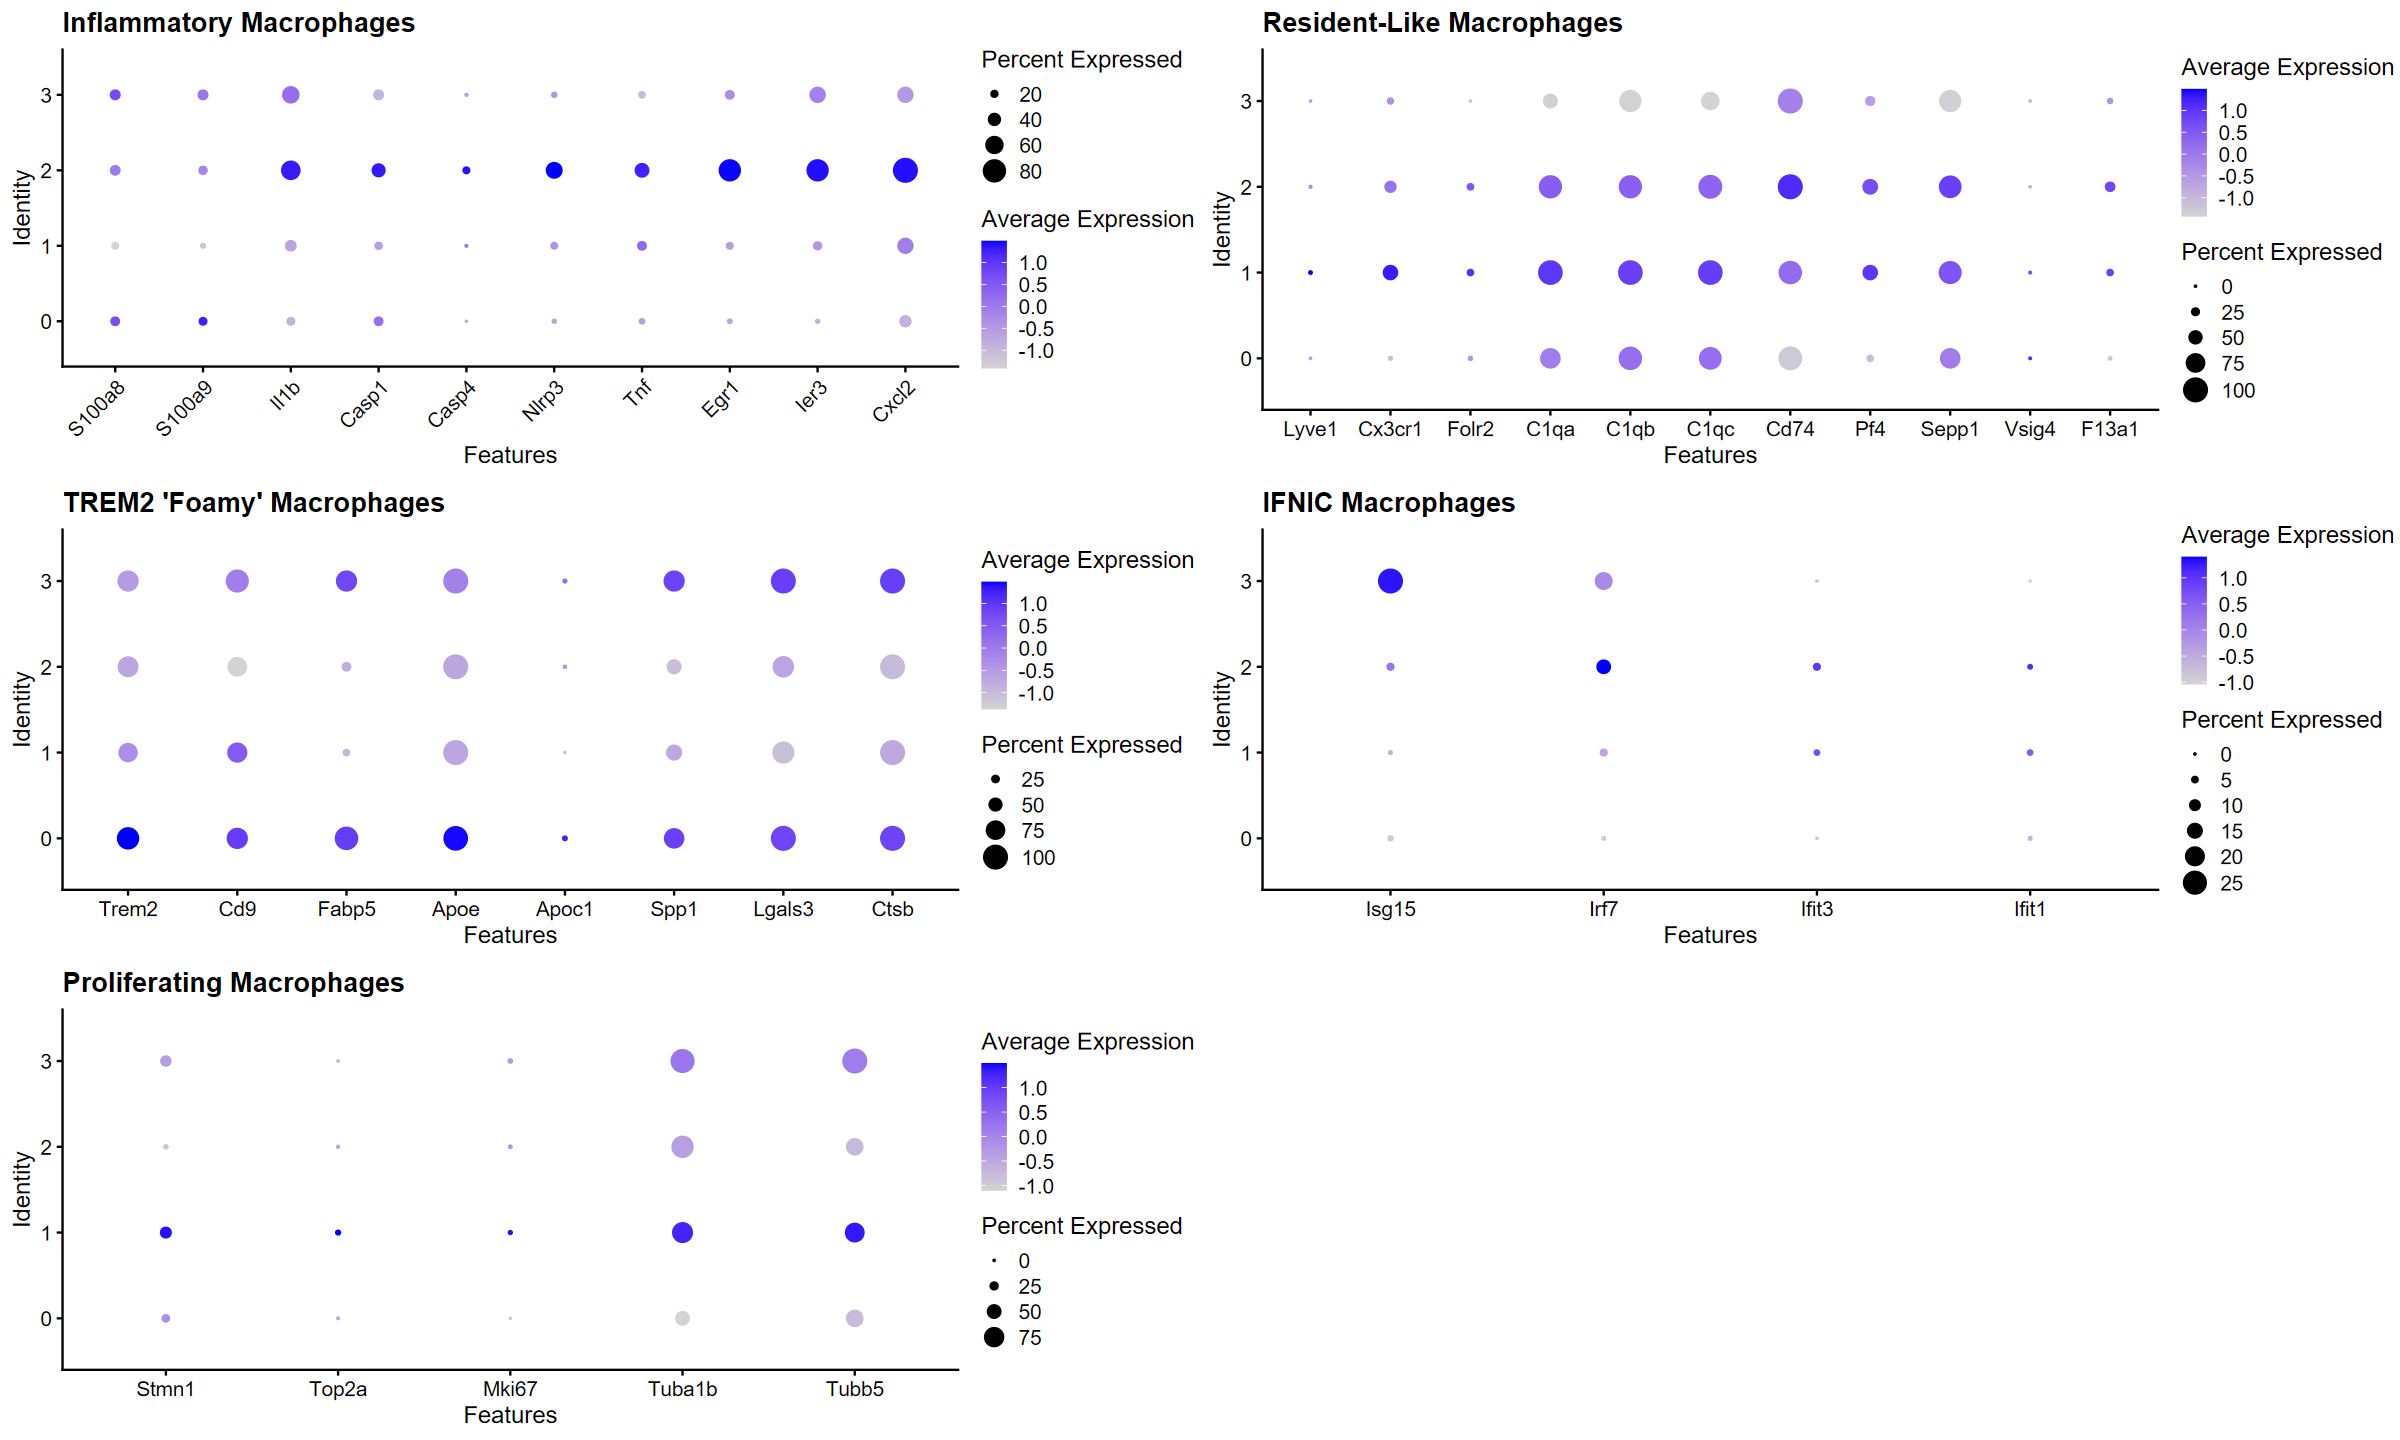

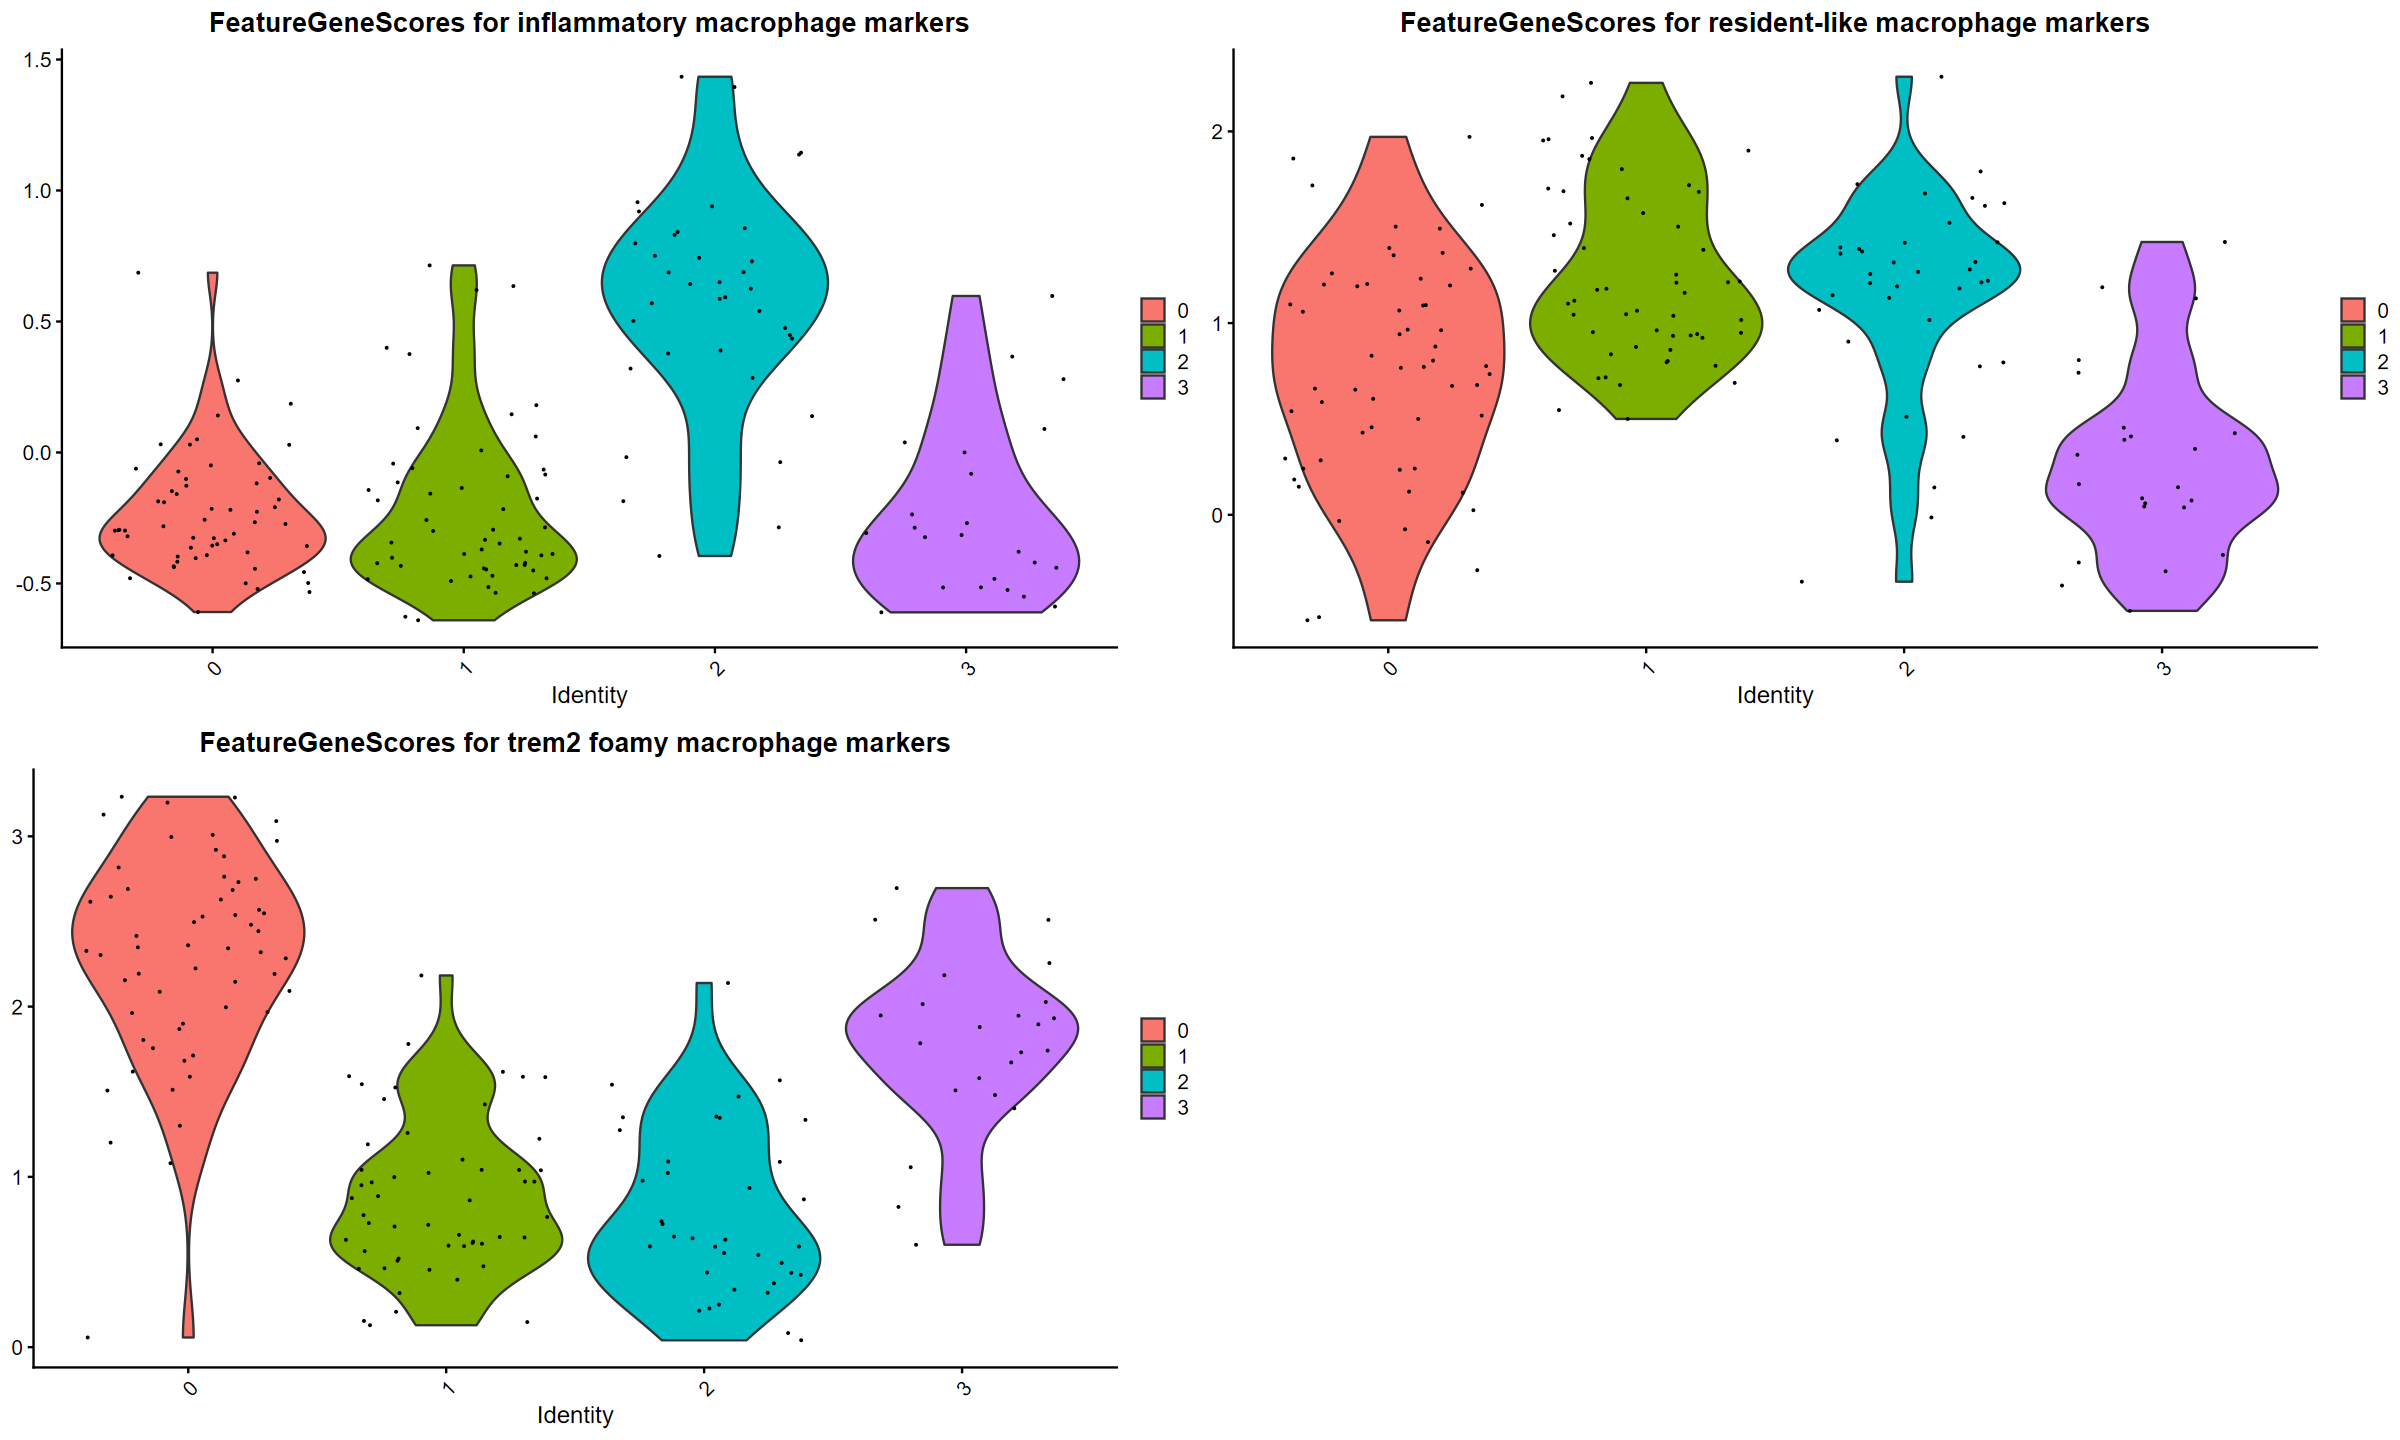

In [46]:
# Plot
grid.arrange(inflammatory_dot, resident_dot, TREM2_dot, IFNIC_dot, proliferating_dot, ncol = 2)
grid.arrange(inflammatory_vln, residents_vln, trem2_vln, ncol=2)


In [47]:
# Assign new labels
macrophage_data <- RenameIdents(macrophage_data,
                                   '0' = 'TREM2 Foamy Macrophages',
                                   '1' = 'Resident-like Macrophages',
                                   '2' = 'Inflammatory Macrophages',
                                   '3' = 'TREM2 Foamy Macrophages')


# Proportion tables
annotations_per_origin <- table(Idents(macrophage_data), macrophage_data$orig.ident)
annotations_per_origin_prop <- prop.table(table(Idents(macrophage_data), macrophage_data$orig.ident), margin = 2) * 100
annotations_total <- prop.table(table(Idents(macrophage_data))) * 100

# Subtype plots after annotation
subtype_annotated_plot <- DimPlot(macrophage_data, reduction = "umap", label = TRUE)
subtype_origin_plot <- DimPlot(macrophage_data, reduction = "umap", group.by = "orig.ident", label = TRUE)


# Combine tables side by side
combined_df <- cbind(annotations_per_origin, annotations_per_origin_prop, annotations_total)

,A11,A12,A11,A12,annotations_total
TREM2 Foamy Macrophages,18,63,81.81818,42.00000,47.09302
Resident-like Macrophages,4,50,18.18182,33.33333,31.39535
Inflammatory Macrophages,0,37,0.00000,24.66667,21.51163


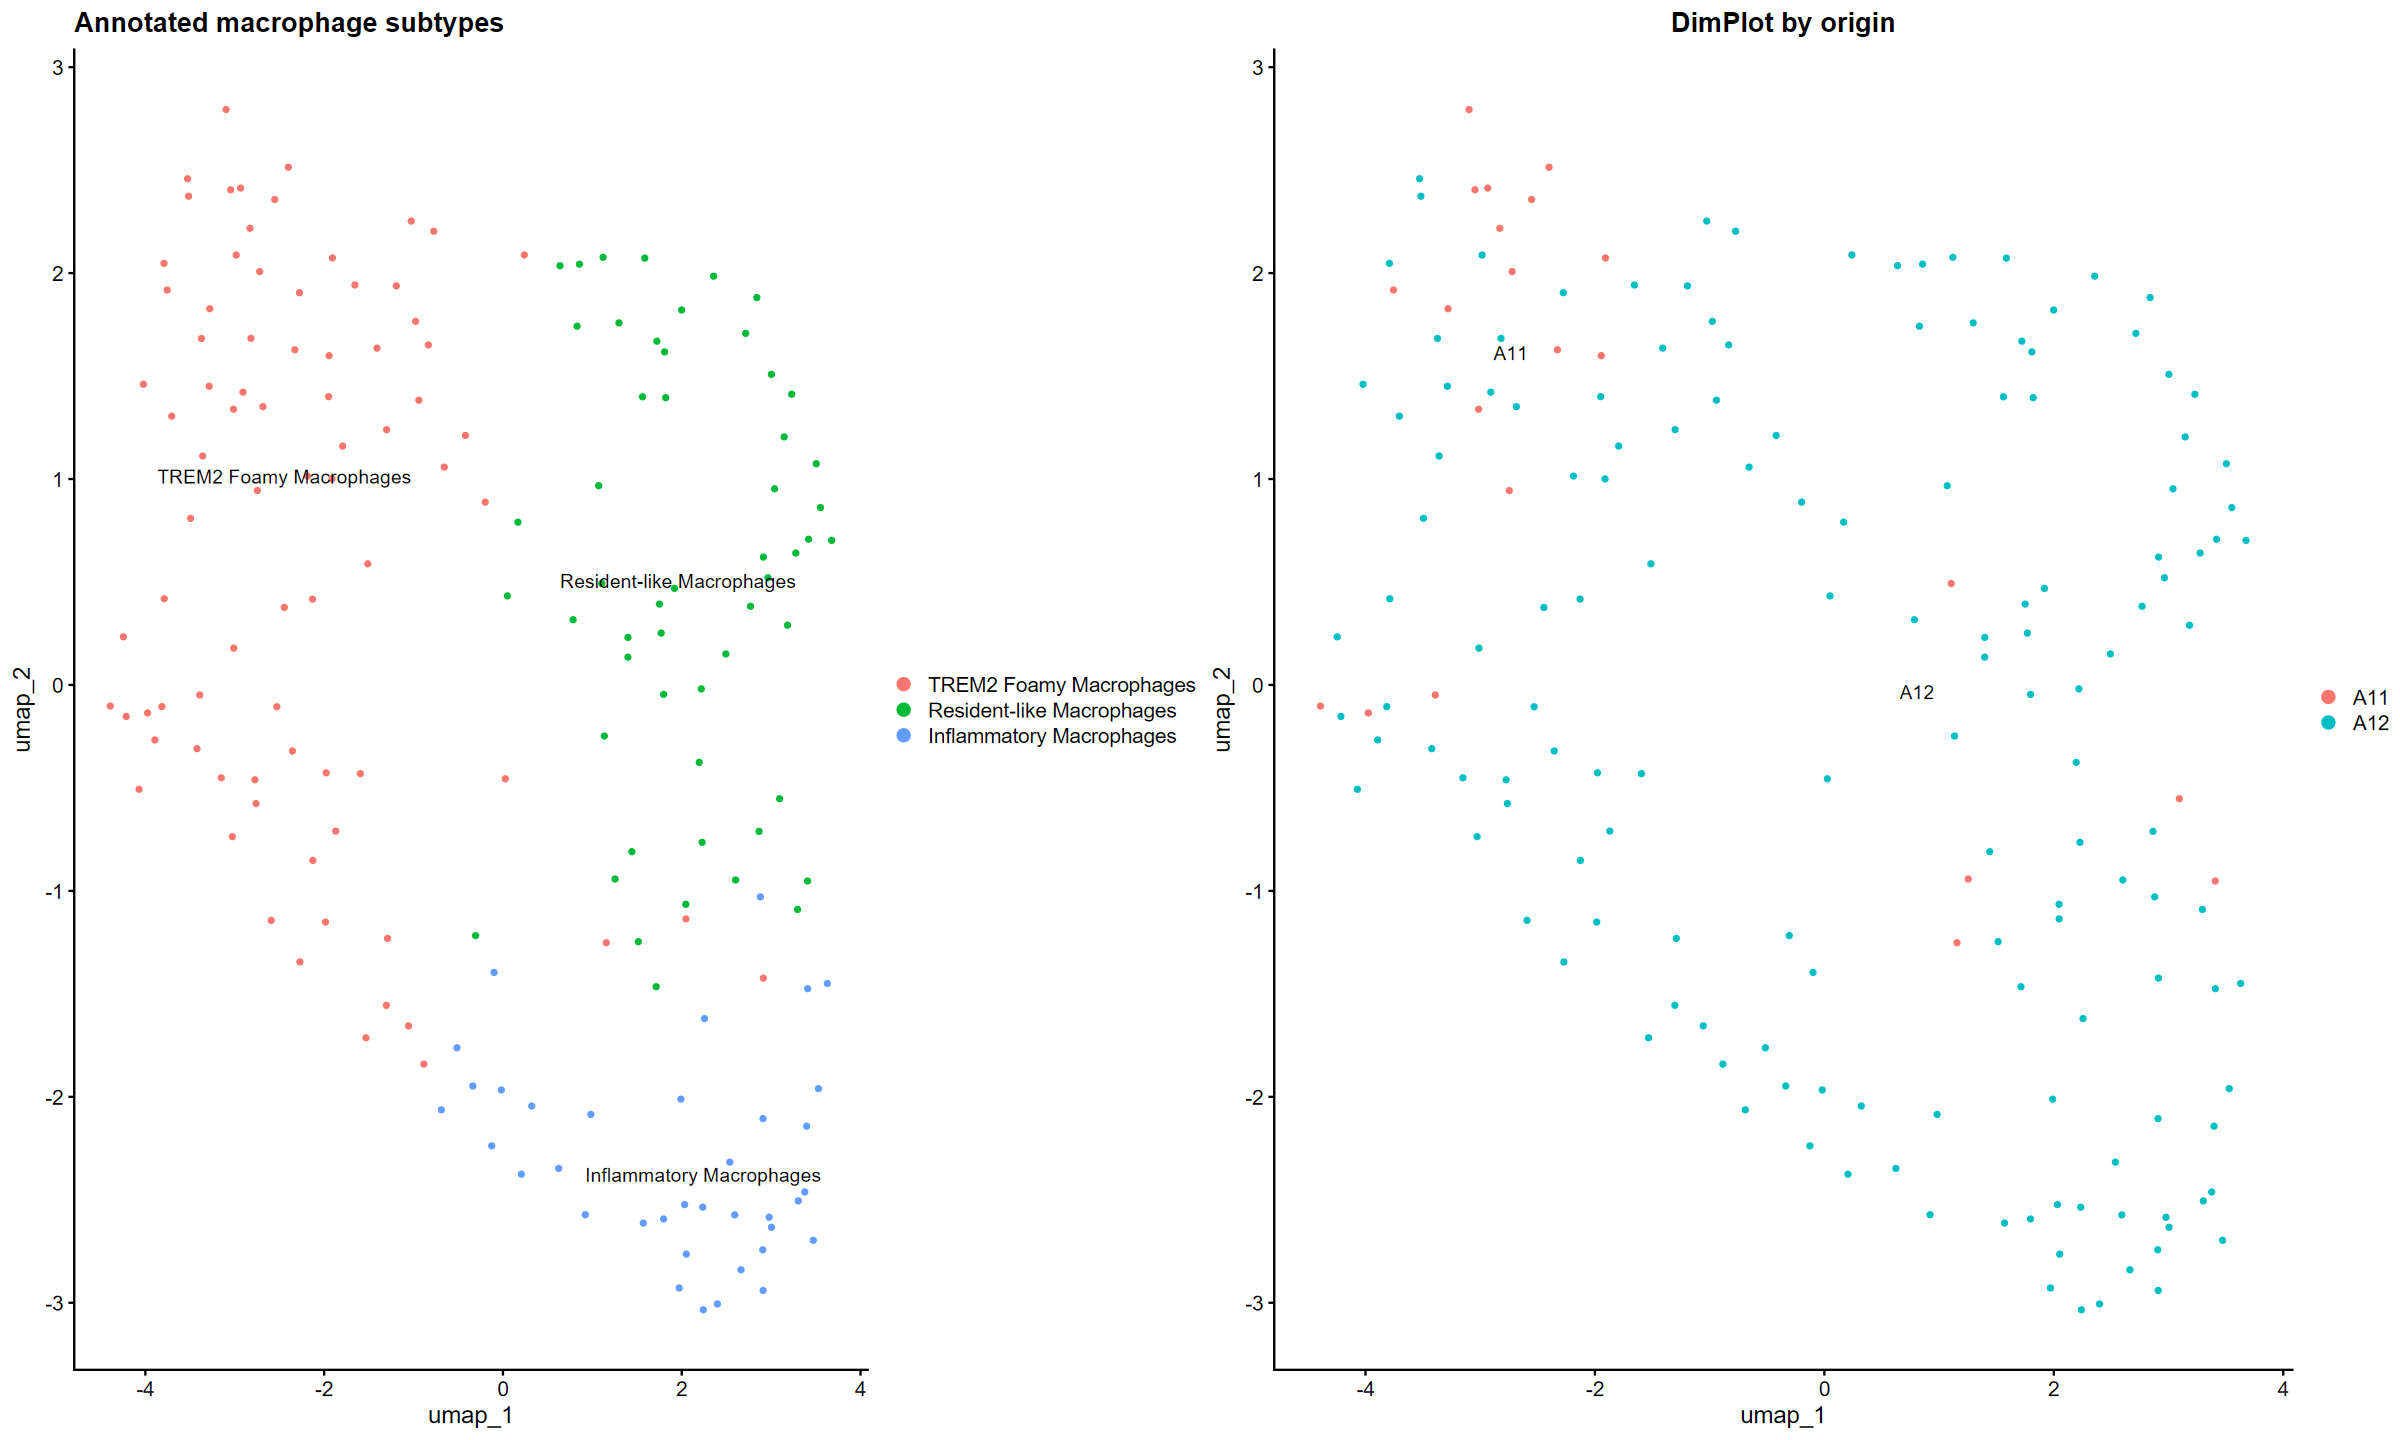

In [48]:
# Plot table
combined_df

# Plotting annotations and titles
grid.arrange(
    subtype_annotated_plot + ggtitle("Annotated macrophage subtypes"),
    subtype_origin_plot + ggtitle("DimPlot by origin"),
    ncol=2
)

In [49]:
# Save final object
saveRDS(macrophage_data, file = "Vafadarnejad_macrophages_annotated.rds")